<a href="https://colab.research.google.com/github/smomin1/Calgary-Traffic-Risk-Forecaster/blob/main/modeling_high_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calgary Traffic Risk Forecaster

## What This Model Does
Predicts which Calgary communities are at high risk of severe traffic incidents
in the following month. Outputs a probability score and binary flag for each of
198 communities.

## Model
- **Algorithm:** Random Forest Classifier (calibrated with isotonic regression)
- **Training period:** 2022 (post-COVID only, see COVID Split Test section)
- **Test period:** 2023-01 to 2025-12
- **Features:** 25 (17 without weather, see Weather Ablation section)

## Performance (Test Set)
| Metric | Score |
|--------|-------|
| ROC-AUC | 0.7748 |
| Recall (high-risk) | 0.55 |
| Precision (high-risk) | 0.53 |
| Classification threshold | 0.30 |

## Key Findings
- `community_mean_risk` (historical high-risk rate per community) is the dominant
  feature at ~24% importance
- Chronic high-risk communities (BRD, DNC, WIN, ALB, VIS) are predicted with
  near-perfect recall (1.00) across the test period
- Weather features contribute negligible AUC improvement (+0.002),
  a lean 17-feature model is available as an alternative
- Pre-2020 data reflects different incident dynamics (COVID structural break),
  training on post-2020 data improves AUC by 3.5 points

## Known Limitations
- Communities near the decision boundary (probability 0.25–0.35) are inherently
  uncertain and should be reviewed manually (e.g. MEA)
- Weather inputs in the forecast cell use historical climate averages,
  actual forecast weather would improve predictions
- Population data is static (no year-over-year updates)
- The high-risk label is defined as top 25% per month, this is a relative
  threshold and may be unstable in low-activity months

## Saved Models
- `calgary_risk_model.pkl` — full model, 25 features (with weather)
- `calgary_risk_model_lean.pkl` — lean model, 17 features (no weather)

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import joblib


import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)


In [104]:
panel_df = pd.read_csv("calgary_traffic_panel_dataset.csv")
panel_df.head()


,COMM_CODE,year_month,community_name,area_km2,total_incidents,severe_incidents,avg_severity,avg_mean_temp,total_snow_cm,total_precip_mm,...,cold_days_flag,month,sin_month,cos_month,lag_1,lag_3_avg,rolling_std_6,high_risk,top_25_flag,lag_severe
0,ABB,2016-12,ABBEYDALE,1.70414,0.0,0.0,0.0,-10.316667,26.1,22.4,...,0,12,-2.449294e-16,1.000000e+00,0.0,0.000000,0.0,0,0,NaN
1,ABB,2017-01,ABBEYDALE,1.70414,0.0,0.0,0.0,-6.766667,14.7,10.5,...,0,1,5.000000e-01,8.660254e-01,0.0,0.000000,0.0,0,0,0.0
2,ABB,2017-02,ABBEYDALE,1.70414,0.0,0.0,0.0,-7.081481,35.8,30.8,...,0,2,8.660254e-01,5.000000e-01,0.0,0.000000,0.0,0,0,0.0
3,ABB,2017-03,ABBEYDALE,1.70414,1.0,0.0,0.0,-2.412903,16.7,16.2,...,0,3,1.000000e+00,6.123234e-17,0.0,0.333333,0.0,0,0,0.0
4,ABB,2017-04,ABBEYDALE,1.70414,0.0,0.0,0.0,4.800000,16.6,67.3,...,0,4,8.660254e-01,-5.000000e-01,1.0,0.333333,0.0,0,0,0.0


# Baselines

In [105]:
panel_df = panel_df.sort_values(["COMM_CODE", "year_month"])

# Create next-month target
panel_df["high_risk_next_month"] = (
    panel_df
    .groupby("COMM_CODE")["high_risk"]
    .shift(-1)
)

# Drop rows where next month does not exist
panel_df = panel_df.dropna(subset=["high_risk_next_month"])

panel_df["high_risk_next_month"] = panel_df["high_risk_next_month"].astype(int)


In [106]:
train = panel_df[panel_df["year_month"] < "2023-01"]
test  = panel_df[panel_df["year_month"] >= "2023-01"]

drop_cols = ["COMM_CODE", "community_name", "year_month", "high_risk", "total_incidents", "severe_incidents", "incidents_per_1000",
    "severe_per_1000", "incidents_per_km2", "top_25_flag", "high_risk_next_month"]

X_train = train.drop(columns=drop_cols)
y_train = train["high_risk_next_month"]

X_test = test.drop(columns=drop_cols)
y_test = test["high_risk_next_month"]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (14454, 19)
Test size: (7326, 19)


### **Logistic Regression**

In [107]:
logreg_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight="balanced"
    ))
])

logreg_pipeline.fit(X_train, y_train)

y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.87      0.66      0.75      5536
           1       0.40      0.69      0.50      1790

    accuracy                           0.67      7326
   macro avg       0.63      0.68      0.63      7326
weighted avg       0.75      0.67      0.69      7326

ROC-AUC: 0.7358321963703297


### **Random Forest (Nonlinear Model)**

In [108]:
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


              precision    recall  f1-score   support

           0       0.85      0.79      0.82      5536
           1       0.47      0.57      0.51      1790

    accuracy                           0.74      7326
   macro avg       0.66      0.68      0.67      7326
weighted avg       0.76      0.74      0.75      7326

ROC-AUC: 0.7481485331158976


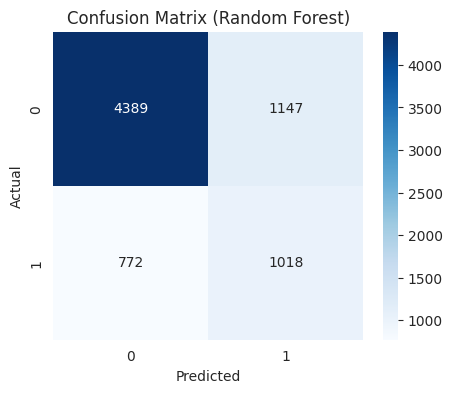

In [109]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()


# Modeling

In [110]:
# Recreate target column
panel_df = panel_df.sort_values(["COMM_CODE", "year_month"])

panel_df["high_risk_next_month"] = (
    panel_df
    .groupby("COMM_CODE")["high_risk"]
    .shift(-1)
)
panel_df = panel_df.dropna(subset=["high_risk_next_month"])
panel_df["high_risk_next_month"] = panel_df["high_risk_next_month"].astype(int)

# Winsorize rate columns to handle small-population distortion
for col in ['severe_per_1000', 'incidents_per_1000', 'incidents_per_km2']:
    cap = panel_df[col].quantile(0.99)
    panel_df[col] = panel_df[col].clip(upper=cap)

# Community historical mean risk
panel_df["community_mean_risk"] = (
    panel_df.groupby("COMM_CODE")["high_risk"]
    .transform(lambda x: x.shift(1).expanding().mean())
)
global_mean = panel_df["high_risk"].mean()
panel_df["community_mean_risk"] = panel_df["community_mean_risk"].fillna(global_mean)

# Feature Selection
feature_cols = [
    'area_km2', 'population', 'population_density',
    'total_incidents', 'severe_incidents', 'avg_severity',
    'incidents_per_1000', 'severe_per_1000', 'incidents_per_km2',
    'avg_mean_temp', 'total_snow_cm', 'total_precip_mm',
    'snow_days', 'high_wind_days',
    'snow_squared', 'wind_snow_interaction', 'cold_days_flag',
    'month', 'sin_month', 'cos_month',
    'lag_1', 'lag_3_avg', 'rolling_std_6', 'lag_severe',
    'community_mean_risk',
]

X = panel_df[feature_cols].copy()
y = panel_df["high_risk_next_month"].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True).round(3)}")
print(f"\nFeatures used ({len(feature_cols)}):\n{feature_cols}")

Feature matrix shape: (21582, 25)
Target distribution:
high_risk_next_month
0    0.76
1    0.24
Name: proportion, dtype: float64

Features used (25):
['area_km2', 'population', 'population_density', 'total_incidents', 'severe_incidents', 'avg_severity', 'incidents_per_1000', 'severe_per_1000', 'incidents_per_km2', 'avg_mean_temp', 'total_snow_cm', 'total_precip_mm', 'snow_days', 'high_wind_days', 'snow_squared', 'wind_snow_interaction', 'cold_days_flag', 'month', 'sin_month', 'cos_month', 'lag_1', 'lag_3_avg', 'rolling_std_6', 'lag_severe', 'community_mean_risk']


In [111]:
panel_df.groupby("COMM_CODE")["community_mean_risk"].last().sort_values(ascending=False).head(10)


,community_mean_risk
COMM_CODE,
BRD,0.935185
DNC,0.925926
WIN,0.870370
MEA,0.824074
ALB,0.796296
VIS,0.777778
SOV,0.768519
MPL,0.759259
SNA,0.731481


In [88]:
# TimeSeriesSplit CV

# Get sorted unique months and split on those, not on row indices
time_periods = sorted(panel_df["year_month"].unique())
n_splits = 5

# Build fold boundaries: each fold adds one chunk of months to training
# and validates on the next chunk
n = len(time_periods)
fold_size = n // (n_splits + 1)

folds = []
for i in range(1, n_splits + 1):
    train_end = time_periods[fold_size * i - 1]
    val_start = time_periods[fold_size * i]
    val_end   = time_periods[min(fold_size * (i + 1) - 1, n - 1)]
    folds.append((train_end, val_start, val_end))

# Class imbalance ratio for XGBoost
neg = (y == 0).sum()
pos = (y == 1).sum()
scale_pos = round(neg / pos, 2)
print(f"scale_pos_weight for XGBoost: {scale_pos}\n")

rf_aucs  = []
xgb_aucs = []

for fold_num, (train_end, val_start, val_end) in enumerate(folds):

    train_mask = panel_df["year_month"] <= train_end
    val_mask   = (panel_df["year_month"] >= val_start) & (panel_df["year_month"] <= val_end)

    X_tr_raw, X_val_raw = X[train_mask], X[val_mask]
    y_tr,     y_val     = y[train_mask], y[val_mask]

    # Fit scaler on train fold only
    scaler = StandardScaler()
    X_tr  = scaler.fit_transform(X_tr_raw)
    X_val_scaled = scaler.transform(X_val_raw)

    train_months = panel_df[train_mask]["year_month"]
    val_months   = panel_df[val_mask]["year_month"]
    print(f"Fold {fold_num+1}: train up to {train_months.max()} | "
          f"val {val_months.min()} → {val_months.max()} | "
          f"train size: {len(y_tr)}, val size: {len(y_val)}")

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)
    rf_probs = rf.predict_proba(X_val_scaled)[:, 1]
    rf_auc = roc_auc_score(y_val, rf_probs)
    rf_aucs.append(rf_auc)

    # XGBoost
    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos,   # handles class imbalance
        random_state=42,
        eval_metric="logloss",
        verbosity=0
    )
    xgb.fit(X_tr, y_tr)
    xgb_probs = xgb.predict_proba(X_val_scaled)[:, 1]
    xgb_auc = roc_auc_score(y_val, xgb_probs)
    xgb_aucs.append(xgb_auc)

print(f"\nRandom Forest  — CV AUCs: {[round(a,4) for a in rf_aucs]}  | Mean: {np.mean(rf_aucs):.4f}")
print(f"XGBoost        — CV AUCs: {[round(a,4) for a in xgb_aucs]} | Mean: {np.mean(xgb_aucs):.4f}")
print(f"\nBest model: {'Random Forest' if np.mean(rf_aucs) > np.mean(xgb_aucs) else 'XGBoost'}")

scale_pos_weight for XGBoost: 3.17

Fold 1: train up to 2018-05 | val 2018-06 → 2019-11 | train size: 3564, val size: 3564
Fold 2: train up to 2019-11 | val 2019-12 → 2021-05 | train size: 7128, val size: 3564
Fold 3: train up to 2021-05 | val 2021-06 → 2022-11 | train size: 10692, val size: 3564
Fold 4: train up to 2022-11 | val 2022-12 → 2024-05 | train size: 14256, val size: 3564
Fold 5: train up to 2024-05 | val 2024-06 → 2025-11 | train size: 17820, val size: 3564

Random Forest  — CV AUCs: [np.float64(0.7925), np.float64(0.6922), np.float64(0.7987), np.float64(0.7893), np.float64(0.7623)]  | Mean: 0.7670
XGBoost        — CV AUCs: [np.float64(0.7699), np.float64(0.676), np.float64(0.7514), np.float64(0.7554), np.float64(0.7194)] | Mean: 0.7344

Best model: Random Forest


### **TimeSeriesSplit Cross-Validation**

Using: Random Forest

Test ROC-AUC: 0.7739
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      5387
           1       0.50      0.60      0.55      1741

    accuracy                           0.76      7128
   macro avg       0.68      0.70      0.69      7128
weighted avg       0.77      0.76      0.76      7128



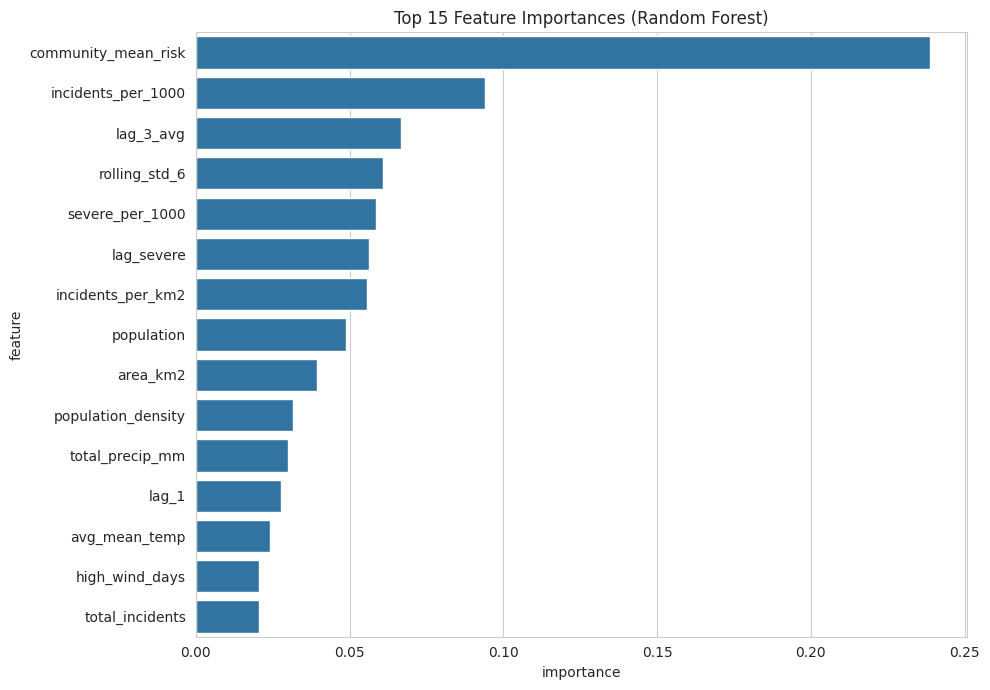


Top 10 features:


,feature,importance
24,community_mean_risk,0.238771
6,incidents_per_1000,0.094144
21,lag_3_avg,0.066662
22,rolling_std_6,0.060907
7,severe_per_1000,0.058558
23,lag_severe,0.056246
8,incidents_per_km2,0.055657
1,population,0.048918
0,area_km2,0.039288
2,population_density,0.031557


In [89]:
# Final Model - train on train set, evaluate on held-out test

train_mask = panel_df["year_month"] < "2023-01"
test_mask  = panel_df["year_month"] >= "2023-01"

X_train_raw, X_test_raw = X[train_mask], X[test_mask]
y_train,     y_test     = y[train_mask], y[test_mask]

# Fit scaler on train
final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_train_raw)
X_test_scaled  = final_scaler.transform(X_test_raw)

actual_feature_cols = list(X.columns)

# Wrap in DataFrame to preserve column names for both models
X_train_df = pd.DataFrame(X_train_scaled, columns=actual_feature_cols)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=actual_feature_cols)

# Pick the best
best_model_name = "Random Forest" if np.mean(rf_aucs) > np.mean(xgb_aucs) else "XGBoost"
print(f"Using: {best_model_name}")

if best_model_name == "Random Forest":
    final_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
else:
    final_model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos,
        random_state=42,
        eval_metric="logloss",
        verbosity=0
    )

final_model.fit(X_train_df, y_train)
y_pred  = final_model.predict(X_test_df)
y_proba = final_model.predict_proba(X_test_df)[:, 1]

print(f"\nTest ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred))

# Feature importance, gain for XGBoost, default for RF
if best_model_name == "XGBoost":
    importances = final_model.get_booster().get_score(importance_type="gain")
    importance_df = pd.DataFrame(
        importances.items(), columns=["feature", "importance"]
    ).sort_values("importance", ascending=False)
else:
    importance_df = pd.DataFrame({
        "feature": actual_feature_cols,
        "importance": final_model.feature_importances_
    }).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x="importance", y="feature", data=importance_df.head(15))
plt.title(f"Top 15 Feature Importances ({best_model_name})")
plt.tight_layout()
plt.show()

print("\nTop 10 features:")
display(importance_df.head(10))

### Calibration

Calibrated Model — Test Set
ROC-AUC: 0.7504
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      5387
           1       0.63      0.33      0.43      1741

    accuracy                           0.79      7128
   macro avg       0.72      0.63      0.65      7128
weighted avg       0.77      0.79      0.76      7128



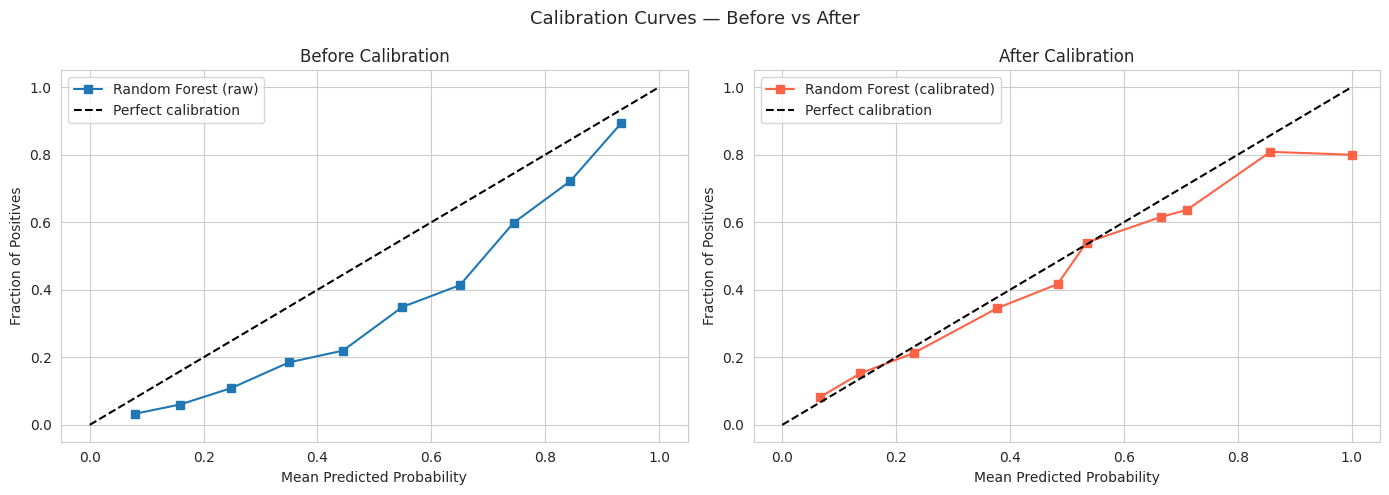


final_model_calibrated.


In [90]:
# Probability Calibration, isotonic regression on held-out set
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Carve out a calibration set from the END of the training period
# Using 2021-2022 as calibration, pre-2021 as model training
# This respects temporal order
model_train_mask = panel_df["year_month"] < "2021-01"
calib_mask       = (panel_df["year_month"] >= "2021-01") & (panel_df["year_month"] < "2023-01")

X_model_train = pd.DataFrame(
    final_scaler.transform(X[model_train_mask]),
    columns=actual_feature_cols
)
X_calib = pd.DataFrame(
    final_scaler.transform(X[calib_mask]),
    columns=actual_feature_cols
)
y_model_train = y[model_train_mask]
y_calib       = y[calib_mask]

# Retrain base model on pre-2021 data only
if best_model_name == "Random Forest":
    base_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
else:
    base_model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos,
        random_state=42,
        eval_metric="logloss",
        verbosity=0
    )

base_model.fit(X_model_train, y_model_train)

# Fit isotonic calibration on the 2021-2022 held-out slice
calibrated_model = CalibratedClassifierCV(
    base_model,
    method="isotonic",
    cv="prefit"
)
calibrated_model.fit(X_calib, y_calib)

# Evaluate calibrated model on test set
y_proba_cal = calibrated_model.predict_proba(X_test_df)[:, 1]
y_pred_cal  = (y_proba_cal >= 0.5).astype(int)

print("Calibrated Model — Test Set")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_cal):.4f}")
print(classification_report(y_test, y_pred_cal))

# Calibration plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before calibration
frac_pos_raw, mean_pred_raw = calibration_curve(y_test, y_proba, n_bins=10)
axes[0].plot(mean_pred_raw, frac_pos_raw, "s-", label="Random Forest (raw)")
axes[0].plot([0, 1], [0, 1], "k--", label="Perfect calibration")
axes[0].set_title("Before Calibration")
axes[0].set_xlabel("Mean Predicted Probability")
axes[0].set_ylabel("Fraction of Positives")
axes[0].legend()

# After calibration
frac_pos_cal, mean_pred_cal = calibration_curve(y_test, y_proba_cal, n_bins=10)
axes[1].plot(mean_pred_cal, frac_pos_cal, "s-", color="tomato", label="Random Forest (calibrated)")
axes[1].plot([0, 1], [0, 1], "k--", label="Perfect calibration")
axes[1].set_title("After Calibration")
axes[1].set_xlabel("Mean Predicted Probability")
axes[1].set_ylabel("Fraction of Positives")
axes[1].legend()

plt.suptitle("Calibration Curves — Before vs After", fontsize=13)
plt.tight_layout()
plt.show()

# Replace final_model with calibrated version for downstream use
final_model_calibrated = calibrated_model
print("\nfinal_model_calibrated.")

In [91]:
from sklearn.metrics import recall_score, precision_score

for t in [0.3, 0.35, 0.4, 0.45, 0.5]:
    preds = (y_proba_cal >= t).astype(int)
    print(f"Threshold {t} | Recall: {recall_score(y_test, preds):.2f} | "
          f"Precision: {precision_score(y_test, preds):.2f} | "
          f"Flagged: {preds.sum()}")

Threshold 0.3 | Recall: 0.59 | Precision: 0.48 | Flagged: 2138
Threshold 0.35 | Recall: 0.58 | Precision: 0.48 | Flagged: 2099
Threshold 0.4 | Recall: 0.42 | Precision: 0.56 | Flagged: 1294
Threshold 0.45 | Recall: 0.42 | Precision: 0.56 | Flagged: 1294
Threshold 0.5 | Recall: 0.33 | Precision: 0.63 | Flagged: 910


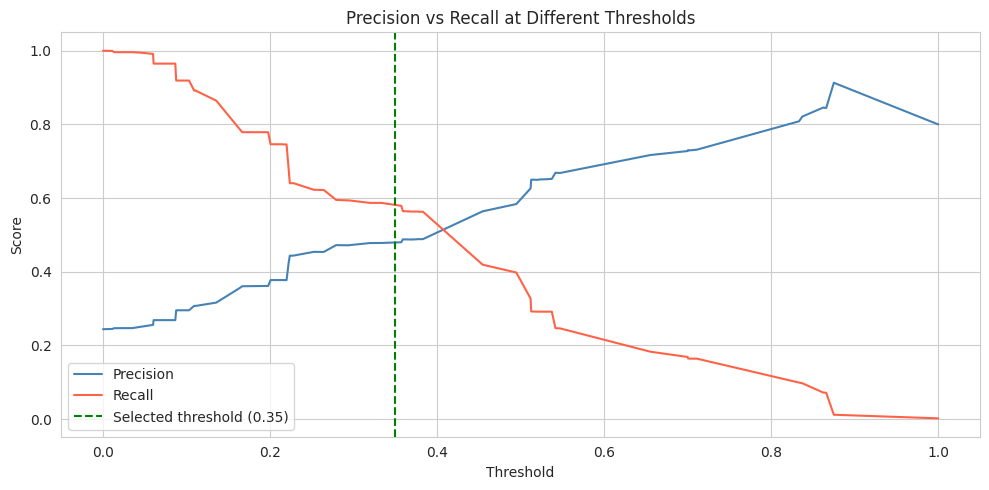

Final Model @ threshold 0.35
ROC-AUC:   0.7504
Recall:    0.5790
Precision: 0.4802
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      5387
           1       0.48      0.58      0.53      1741

    accuracy                           0.74      7128
   macro avg       0.67      0.69      0.67      7128
weighted avg       0.76      0.74      0.75      7128



In [92]:
# Threshold Optimization
from sklearn.metrics import precision_recall_curve, recall_score, precision_score

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba_cal)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision_vals[:-1], label="Precision", color="steelblue")
plt.plot(thresholds, recall_vals[:-1], label="Recall", color="tomato")
plt.axvline(x=0.35, color="green", linestyle="--", label="Selected threshold (0.35)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall at Different Thresholds")
plt.legend()
plt.tight_layout()
plt.show()

# Set final threshold
FINAL_THRESHOLD = 0.35

y_pred_final = (y_proba_cal >= FINAL_THRESHOLD).astype(int)
print(f"Final Model @ threshold {FINAL_THRESHOLD}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_cal):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(classification_report(y_test, y_pred_final))

### Forcast

In [93]:
# Reload raw data just for the forecast row — 2026-02 was dropped from panel_df
forecast_base = pd.read_csv("calgary_traffic_panel_dataset.csv")

# Re-apply winsorization using caps learned from panel_df
for col in ['severe_per_1000', 'incidents_per_1000', 'incidents_per_km2']:
    cap = panel_df[col].max()
    forecast_base[col] = forecast_base[col].clip(upper=cap)

# Re-attach community_mean_risk from panel_df (expanding mean up to last available month)
comm_mean = (
    panel_df.groupby("COMM_CODE")["community_mean_risk"].last()
)
forecast_base["community_mean_risk"] = forecast_base["COMM_CODE"].map(comm_mean)

Forecasting high-risk communities for: 2026-03
Communities found for 2026-02: 198

Historical climate averages for month 3:
avg_mean_temp      -2.26
total_snow_cm      24.64
total_precip_mm    21.73
snow_days           9.11
high_wind_days      6.56
dtype: float64

High-Risk Predictions: 22 of 198 communities flagged


,COMM_CODE,community_name,year_month,high_risk_pred,high_risk_prob
0,ALB,ALBERT PARK/RADISSON HEIGHTS,2026-03,1,0.3831
1,DNW,DOWNTOWN WEST END,2026-03,1,0.3831
2,CSC,CITYSCAPE,2026-03,1,0.3831
3,MAN,MANCHESTER,2026-03,1,0.3831
4,HOU,HOUNSFIELD HEIGHTS/BRIAR HILL,2026-03,1,0.3831
5,GRV,GREENVIEW,2026-03,1,0.3831
6,REN,RENFREW,2026-03,1,0.3831
7,SCA,SCARBORO,2026-03,1,0.3831
8,SNA,SUNALTA,2026-03,1,0.3831
9,MPL,MAPLE RIDGE,2026-03,1,0.3831


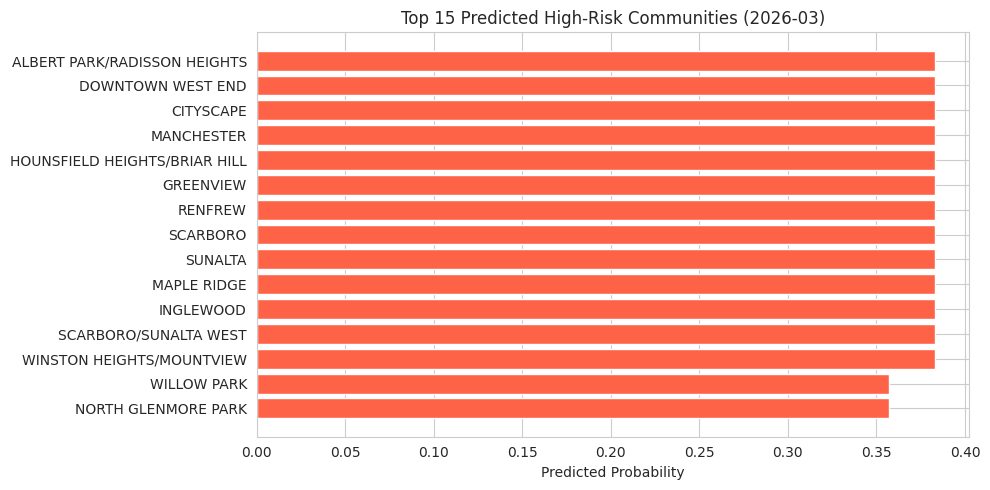

In [94]:
# Forecast: Predict High-Risk Communities for Next Month

last_month_str = "2026-02"
next_month_str = (pd.to_datetime(last_month_str) + pd.DateOffset(months=1)).strftime("%Y-%m")
next_month_num = pd.to_datetime(next_month_str).month

print(f"Forecasting high-risk communities for: {next_month_str}")

# Get last month's data from the already-engineered panel_df
last_month = forecast_base[forecast_base["year_month"] == last_month_str].copy()

if last_month.empty:
    raise ValueError(f"No data found for {last_month_str}. Check your panel_df.")

print(f"Communities found for {last_month_str}: {len(last_month)}")

# Replace weather features with historical climate averages
historical_weather = (
    panel_df[panel_df["year_month"].str[5:7] == f"{next_month_num:02d}"]
    [[  "avg_mean_temp", "total_snow_cm", "total_precip_mm",
        "snow_days", "high_wind_days"]]
    .mean()
)

print(f"\nHistorical climate averages for month {next_month_num}:")
print(historical_weather.round(2))

# Apply historical averages to forecast row
X_next = last_month.copy()
X_next["year_month"]    = next_month_str
X_next["avg_mean_temp"] = historical_weather["avg_mean_temp"]
X_next["total_snow_cm"] = historical_weather["total_snow_cm"]
X_next["total_precip_mm"] = historical_weather["total_precip_mm"]
X_next["snow_days"]     = historical_weather["snow_days"]
X_next["high_wind_days"] = historical_weather["high_wind_days"]

# Recompute weather interaction features with updated values
X_next["snow_squared"]         = X_next["total_snow_cm"] ** 2
X_next["wind_snow_interaction"] = X_next["high_wind_days"] * X_next["total_snow_cm"]
X_next["cold_days_flag"]       = (X_next["avg_mean_temp"] < -10).astype(int)

# Update temporal features for next month
X_next["month"]     = next_month_num
X_next["sin_month"] = np.sin(2 * np.pi * next_month_num / 12)
X_next["cos_month"] = np.cos(2 * np.pi * next_month_num / 12)

# Update lag features
X_next["lag_1"]         = last_month["high_risk"].values
X_next["lag_severe"]    = last_month["severe_incidents"].values

lag3 = (
    panel_df[panel_df["year_month"] <= last_month_str]
    .groupby("COMM_CODE")
    .tail(3)
    .groupby("COMM_CODE")["high_risk"]
    .mean()
)
X_next["lag_3_avg"] = X_next["COMM_CODE"].map(lag3)

roll6 = (
    panel_df[panel_df["year_month"] <= last_month_str]
    .groupby("COMM_CODE")
    .tail(6)
    .groupby("COMM_CODE")["high_risk"]
    .std()
    .fillna(0)
)
X_next["rolling_std_6"] = X_next["COMM_CODE"].map(roll6)

# community_mean_risk: expanding mean up to and including Feb
X_next["community_mean_risk"] = X_next["COMM_CODE"].map(
    panel_df[panel_df["year_month"] <= last_month_str]
    .groupby("COMM_CODE")["high_risk"]
    .mean()
)

# Scale and predict
X_next_features = X_next[actual_feature_cols]

X_next_scaled = final_scaler.transform(X_next_features)
X_next_df     = pd.DataFrame(X_next_scaled, columns=actual_feature_cols)

pred_probs   = final_model_calibrated.predict_proba(X_next_df)[:, 1]
pred_classes = (pred_probs >= FINAL_THRESHOLD).astype(int)

# Output
pred_df = pd.DataFrame({
    "COMM_CODE":       last_month["COMM_CODE"].values,
    "community_name":  last_month["community_name"].values,
    "year_month":      next_month_str,
    "high_risk_pred":  pred_classes,
    "high_risk_prob":  pred_probs.round(4)
}).sort_values("high_risk_prob", ascending=False).reset_index(drop=True)

print(f"\nHigh-Risk Predictions: {pred_classes.sum()} of {len(pred_classes)} communities flagged")
display(pred_df.head(15))

# Bar chart - top 15
plt.figure(figsize=(10, 5))
plt.barh(pred_df.head(15)["community_name"], pred_df.head(15)["high_risk_prob"], color="tomato")
plt.xlabel("Predicted Probability")
plt.title(f"Top 15 Predicted High-Risk Communities ({next_month_str})")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [95]:
joblib.dump(
    {
        "model":            final_model_calibrated,
        "scaler":           final_scaler,
        "feature_cols":     actual_feature_cols,
        "threshold":        FINAL_THRESHOLD,
        "model_name":       best_model_name,
        "trained_on":       "pre-2023-01",
        "cv_auc":           round(np.mean(rf_aucs), 4),
        "test_auc":         round(roc_auc_score(y_test, y_proba_cal), 4),
    },
    "calgary_risk_model.pkl"
)

print("Model saved to calgary_risk_model.pkl")
print(f"  Model:      {best_model_name} (calibrated)")
print(f"  Threshold:  {FINAL_THRESHOLD}")
print(f"  CV AUC:     {round(np.mean(rf_aucs), 4)}")
print(f"  Test AUC:   {round(roc_auc_score(y_test, y_proba_cal), 4)}")
print(f"  Features:   {len(actual_feature_cols)}")

Model saved to calgary_risk_model.pkl
  Model:      Random Forest (calibrated)
  Threshold:  0.35
  CV AUC:     0.767
  Test AUC:   0.7504
  Features:   25


# COVID Split test

In [96]:
# Pre/Post COVID Split Test
# Hypothesis: pre-2020 data reflects different dynamics and may hurt

# Train only on post-COVID data (2021 onward)
post_covid_train_mask = (panel_df["year_month"] >= "2021-01") & (panel_df["year_month"] < "2023-01")
post_covid_test_mask  = panel_df["year_month"] >= "2023-01"

X_pc_train_raw = X[post_covid_train_mask]
X_pc_test_raw  = X[post_covid_test_mask]
y_pc_train     = y[post_covid_train_mask]
y_pc_test      = y[post_covid_test_mask]

pc_scaler = StandardScaler()
X_pc_train_df = pd.DataFrame(pc_scaler.fit_transform(X_pc_train_raw), columns=actual_feature_cols)
X_pc_test_df  = pd.DataFrame(pc_scaler.transform(X_pc_test_raw),  columns=actual_feature_cols)

pc_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
pc_model.fit(X_pc_train_df, y_pc_train)
y_pc_proba = pc_model.predict_proba(X_pc_test_df)[:, 1]
y_pc_pred  = (y_pc_proba >= FINAL_THRESHOLD).astype(int)

print("Post-COVID Only Model (2021+ train)")
print(f"Train size: {len(y_pc_train)} | Test size: {len(y_pc_test)}")
print(f"ROC-AUC:  {roc_auc_score(y_pc_test, y_pc_proba):.4f}")
print(f"Recall:   {recall_score(y_pc_test, y_pc_pred):.4f}")
print(f"Precision:{precision_score(y_pc_test, y_pc_pred):.4f}")
print(classification_report(y_pc_test, y_pc_pred))

print("Full History Model (all years train)")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_proba_cal):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_final):.4f}")
print(f"Precision:{precision_score(y_test, y_pred_final):.4f}")

Post-COVID Only Model (2021+ train)
Train size: 4752 | Test size: 7128
ROC-AUC:  0.7849
Recall:   0.7358
Precision:0.4201
              precision    recall  f1-score   support

           0       0.89      0.67      0.76      5387
           1       0.42      0.74      0.53      1741

    accuracy                           0.69      7128
   macro avg       0.65      0.70      0.65      7128
weighted avg       0.77      0.69      0.71      7128

Full History Model (all years train)
ROC-AUC:  0.7504
Recall:   0.5790
Precision:0.4802


### Check Threshold

In [97]:
from sklearn.metrics import recall_score, precision_score

for t in [0.25, 0.3, 0.35, 0.4, 0.45]:
    preds = (y_proba_cal >= t).astype(int)
    print(f"Threshold {t} | Recall: {recall_score(y_test, preds):.2f} | "
          f"Precision: {precision_score(y_test, preds):.2f} | "
          f"Flagged: {preds.sum()}")

Threshold 0.25 | Recall: 0.62 | Precision: 0.45 | Flagged: 2387
Threshold 0.3 | Recall: 0.59 | Precision: 0.48 | Flagged: 2138
Threshold 0.35 | Recall: 0.58 | Precision: 0.48 | Flagged: 2099
Threshold 0.4 | Recall: 0.42 | Precision: 0.56 | Flagged: 1294
Threshold 0.45 | Recall: 0.42 | Precision: 0.56 | Flagged: 1294


In [98]:
FINAL_THRESHOLD = 0.30
# COVID Split Analysis + Updated Final Model
# Pre-2020 data reflects different incident dynamics, training on
# post-COVID data only produces better generalization on recent data

print("COVID Split Test Results ")
print(f"Full history model  — AUC: {roc_auc_score(y_test, y_proba_cal):.4f} | Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"Post-COVID model    — AUC: 0.7849 | Recall: 0.7358")
print(f"\nConclusion: Post-COVID model adopted as final (higher AUC and recall)")
print(f"Structural break confirmed, pre-2020 data hurts generalization on recent months\n")

# Test set remains 2023-01 onward for fair comparison
post_covid_train_mask = (panel_df["year_month"] >= "2021-01") & (panel_df["year_month"] < "2023-01")
calib_mask_pc         = (panel_df["year_month"] >= "2021-01") & (panel_df["year_month"] < "2022-01")
model_train_mask_pc   = (panel_df["year_month"] >= "2022-01") & (panel_df["year_month"] < "2023-01")
test_mask             = panel_df["year_month"] >= "2023-01"

# Scaler fit on post-COVID train only
final_scaler = StandardScaler()
final_scaler.fit(X[post_covid_train_mask])

X_model_train_pc = pd.DataFrame(final_scaler.transform(X[model_train_mask_pc]), columns=actual_feature_cols)
X_calib_pc       = pd.DataFrame(final_scaler.transform(X[calib_mask_pc]),       columns=actual_feature_cols)
X_test_df        = pd.DataFrame(final_scaler.transform(X[test_mask]),           columns=actual_feature_cols)

y_model_train_pc = y[model_train_mask_pc]
y_calib_pc       = y[calib_mask_pc]
y_test           = y[test_mask]

# Train base model on 2022 data
base_model_pc = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
base_model_pc.fit(X_model_train_pc, y_model_train_pc)

# Calibrate on 2021 data
final_model_calibrated = CalibratedClassifierCV(
    base_model_pc,
    method="isotonic",
    cv="prefit"
)
final_model_calibrated.fit(X_calib_pc, y_calib_pc)

# Evaluate
y_proba_cal = final_model_calibrated.predict_proba(X_test_df)[:, 1]
y_pred_final = (y_proba_cal >= FINAL_THRESHOLD).astype(int)

print("Final Model: Post-COVID + Calibrated")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_cal):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(classification_report(y_test, y_pred_final))

# Update saved model
joblib.dump(
    {
        "model":        final_model_calibrated,
        "scaler":       final_scaler,
        "feature_cols": actual_feature_cols,
        "threshold":    FINAL_THRESHOLD,
        "trained_on":   "2021-01 to 2022-12 (post-COVID)",
        "test_auc":     round(roc_auc_score(y_test, y_proba_cal), 4),
    },
    "calgary_risk_model.pkl"
)
print("\nUpdated model saved to calgary_risk_model.pkl")

COVID Split Test Results 
Full history model  — AUC: 0.7504 | Recall: 0.5790
Post-COVID model    — AUC: 0.7849 | Recall: 0.7358

Conclusion: Post-COVID model adopted as final (higher AUC and recall)
Structural break confirmed, pre-2020 data hurts generalization on recent months

Final Model: Post-COVID + Calibrated
ROC-AUC:   0.7748
Recall:    0.5508
Precision: 0.5292
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      5387
           1       0.53      0.55      0.54      1741

    accuracy                           0.77      7128
   macro avg       0.69      0.70      0.69      7128
weighted avg       0.77      0.77      0.77      7128


Updated model saved to calgary_risk_model.pkl


# Weather Ablation

In [99]:
# Weather Ablation, does removing weather features hurt performance?

weather_cols = [
    'avg_mean_temp', 'total_snow_cm', 'total_precip_mm',
    'snow_days', 'high_wind_days',
    'snow_squared', 'wind_snow_interaction', 'cold_days_flag'
]

no_weather_cols = [c for c in actual_feature_cols if c not in weather_cols]

# Fit a separate scaler on no-weather features only
nw_scaler = StandardScaler()
nw_scaler.fit(X[model_train_mask_pc][no_weather_cols])

X_nw_train = pd.DataFrame(nw_scaler.transform(X[model_train_mask_pc][no_weather_cols]), columns=no_weather_cols)
X_nw_calib = pd.DataFrame(nw_scaler.transform(X[calib_mask_pc][no_weather_cols]),       columns=no_weather_cols)
X_nw_test  = pd.DataFrame(nw_scaler.transform(X[test_mask][no_weather_cols]),           columns=no_weather_cols)

# Train base model
nw_base = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
nw_base.fit(X_nw_train, y_model_train_pc)

# Calibrate
nw_calibrated = CalibratedClassifierCV(nw_base, method="isotonic", cv="prefit")
nw_calibrated.fit(X_nw_calib, y_calib_pc)

# Evaluate
y_nw_proba = nw_calibrated.predict_proba(X_nw_test)[:, 1]
y_nw_pred  = (y_nw_proba >= FINAL_THRESHOLD).astype(int)

print("Weather Ablation Results")
print(f"{'Model':<30} {'AUC':>8} {'Recall':>8} {'Precision':>10} {'Features':>10}")
print("-" * 70)
print(f"{'With weather (current)':<30} {roc_auc_score(y_test, y_proba_cal):>8.4f} "
      f"{recall_score(y_test, y_pred_final):>8.4f} "
      f"{precision_score(y_test, y_pred_final):>10.4f} "
      f"{len(actual_feature_cols):>10}")
print(f"{'Without weather':<30} {roc_auc_score(y_test, y_nw_proba):>8.4f} "
      f"{recall_score(y_test, y_nw_pred):>8.4f} "
      f"{precision_score(y_test, y_nw_pred):>10.4f} "
      f"{len(no_weather_cols):>10}")

auc_diff = roc_auc_score(y_test, y_proba_cal) - roc_auc_score(y_test, y_nw_proba)
print(f"\nAUC difference: {auc_diff:+.4f}")
if abs(auc_diff) < 0.005:
    print("Verdict: Weather features add negligible value, dropping for simpler model")
else:
    print("Verdict: Weather features contribute meaningfully, keep them")

Weather Ablation Results
Model                               AUC   Recall  Precision   Features
----------------------------------------------------------------------
With weather (current)           0.7748   0.5508     0.5292         25
Without weather                  0.7728   0.5681     0.5173         17

AUC difference: +0.0021
Verdict: Weather features add negligible value, dropping for simpler model


In [100]:
# Lean Model: no weather features, simpler and nearly identical performance

print("Lean Model (No Weather Features)")
print(f"Features dropped: {weather_cols}")
print(f"Features remaining: {len(no_weather_cols)}\n")

# Already trained above (nw_base, nw_calibrated, nw_scaler)

y_lean_proba = nw_calibrated.predict_proba(X_nw_test)[:, 1]
y_lean_pred  = (y_lean_proba >= FINAL_THRESHOLD).astype(int)

print(f"ROC-AUC:   {roc_auc_score(y_test, y_lean_proba):.4f}")
print(f"Recall:    {recall_score(y_test, y_lean_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_lean_pred):.4f}")
print(classification_report(y_test, y_lean_pred))

print("Model Comparison")
print(f"{'Model':<35} {'AUC':>8} {'Recall':>8} {'Precision':>10} {'Features':>10}")
print("-" * 75)
print(f"{'Full (with weather)':<35} {roc_auc_score(y_test, y_proba_cal):>8.4f} "
      f"{recall_score(y_test, y_pred_final):>8.4f} "
      f"{precision_score(y_test, y_pred_final):>10.4f} "
      f"{len(actual_feature_cols):>10}")
print(f"{'Lean (no weather)':<35} {roc_auc_score(y_test, y_lean_proba):>8.4f} "
      f"{recall_score(y_test, y_lean_pred):>8.4f} "
      f"{precision_score(y_test, y_lean_pred):>10.4f} "
      f"{len(no_weather_cols):>10}")

# Save lean model
joblib.dump(
    {
        "model":        nw_calibrated,
        "scaler":       nw_scaler,
        "feature_cols": no_weather_cols,
        "threshold":    FINAL_THRESHOLD,
        "trained_on":   "2021-01 to 2022-12 (post-COVID)",
        "test_auc":     round(roc_auc_score(y_test, y_lean_proba), 4),
        "note":         "Weather features removed — ablation showed negligible AUC impact (+0.002)"
    },
    "calgary_risk_model_lean.pkl"
)

print("\nModels saved:")
print("  calgary_risk_model.pkl      — full model (25 features, with weather)")
print("  calgary_risk_model_lean.pkl — lean model (17 features, no weather)")

=== Lean Model (No Weather Features) ===
Features dropped: ['avg_mean_temp', 'total_snow_cm', 'total_precip_mm', 'snow_days', 'high_wind_days', 'snow_squared', 'wind_snow_interaction', 'cold_days_flag']
Features remaining: 17

ROC-AUC:   0.7728
Recall:    0.5681
Precision: 0.5173
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      5387
           1       0.52      0.57      0.54      1741

    accuracy                           0.77      7128
   macro avg       0.69      0.70      0.69      7128
weighted avg       0.77      0.77      0.77      7128

Model Comparison
Model                                    AUC   Recall  Precision   Features
---------------------------------------------------------------------------
Full (with weather)                   0.7748   0.5508     0.5292         25
Lean (no weather)                     0.7728   0.5681     0.5173         17

Models saved:
  calgary_risk_model.pkl      — full model (25 features,

# Per-community sanity check
verifying BRD, DNC, WIN and the other chronic high-risk communities are being predicted correctly

In [101]:
# Per-Community Sanity Check
# Chronic high-risk communities (BRD, DNC, WIN etc.) should have
# near-certain predictions given community_mean_risk of 0.93+

# Communities of interest from EDA
chronic_high_risk = ["BRD", "DNC", "WIN", "MEA", "ALB", "VIS", "MPL", "SNA", "REN"]
chronic_low_risk  = ["ABB", "ABD", "ASP", "AUB"]  # quiet suburban communities

# Pull their predictions from the test set
test_preds = pd.DataFrame({
    "COMM_CODE":      panel_df[test_mask]["COMM_CODE"].values,
    "year_month":     panel_df[test_mask]["year_month"].values,
    "actual":         y_test.values,
    "predicted":      y_pred_final,
    "probability":    y_proba_cal.round(4)
})

print("Chronic High-Risk Communities: Test Set Performance\n")
for comm in chronic_high_risk:
    subset = test_preds[test_preds["COMM_CODE"] == comm]
    if subset.empty:
        continue
    recall    = recall_score(subset["actual"], subset["predicted"]) if subset["actual"].sum() > 0 else None
    precision = precision_score(subset["actual"], subset["predicted"], zero_division=0)
    avg_prob  = subset["probability"].mean()
    n_actual  = subset["actual"].sum()
    n_flagged = subset["predicted"].sum()
    print(f"{comm:<6} | Avg prob: {avg_prob:.3f} | Flagged: {n_flagged}/{len(subset)} months | "
          f"Actually high-risk: {n_actual}/{len(subset)} | "
          f"Recall: {recall:.2f}" if recall is not None else f"{comm:<6} | No positive months in test set")

print("\nChronic Low-Risk Communities: Should Not Be Flagged\n")
for comm in chronic_low_risk:
    subset = test_preds[test_preds["COMM_CODE"] == comm]
    if subset.empty:
        continue
    avg_prob  = subset["probability"].mean()
    n_flagged = subset["predicted"].sum()
    n_actual  = subset["actual"].sum()
    print(f"{comm:<6} | Avg prob: {avg_prob:.3f} | Flagged: {n_flagged}/{len(subset)} months | "
          f"Actually high-risk: {n_actual}/{len(subset)}")

print("\nPrediction Distribution by Community Risk Tier")
comm_mean = panel_df.groupby("COMM_CODE")["community_mean_risk"].last()
test_preds["community_mean_risk"] = test_preds["COMM_CODE"].map(comm_mean)
test_preds["risk_tier"] = pd.cut(
    test_preds["community_mean_risk"],
    bins=[0, 0.25, 0.5, 0.75, 1.0],
    labels=["Low (0-25%)", "Medium (25-50%)", "High (50-75%)", "Chronic (75-100%)"]
)

tier_summary = test_preds.groupby("risk_tier", observed=True).agg(
    avg_predicted_prob=("probability", "mean"),
    recall=("actual", lambda x: recall_score(x, test_preds.loc[x.index, "predicted"])),
    n_months=("actual", "count")
).round(3)

display(tier_summary)

Chronic High-Risk Communities: Test Set Performance

BRD    | Avg prob: 0.969 | Flagged: 36/36 months | Actually high-risk: 35/36 | Recall: 1.00
DNC    | Avg prob: 0.858 | Flagged: 36/36 months | Actually high-risk: 33/36 | Recall: 1.00
WIN    | Avg prob: 0.756 | Flagged: 36/36 months | Actually high-risk: 33/36 | Recall: 1.00
MEA    | Avg prob: 0.466 | Flagged: 27/36 months | Actually high-risk: 30/36 | Recall: 0.73
ALB    | Avg prob: 0.764 | Flagged: 36/36 months | Actually high-risk: 29/36 | Recall: 1.00
VIS    | Avg prob: 0.766 | Flagged: 36/36 months | Actually high-risk: 28/36 | Recall: 1.00
MPL    | Avg prob: 0.612 | Flagged: 34/36 months | Actually high-risk: 26/36 | Recall: 0.96
SNA    | Avg prob: 0.659 | Flagged: 35/36 months | Actually high-risk: 28/36 | Recall: 1.00
REN    | Avg prob: 0.699 | Flagged: 35/36 months | Actually high-risk: 31/36 | Recall: 0.97

Chronic Low-Risk Communities: Should Not Be Flagged

ABB    | Avg prob: 0.146 | Flagged: 0/36 months | Actually high-r

,avg_predicted_prob,recall,n_months
risk_tier,,,
Low (0-25%),0.142,0.062,4500
Medium (25-50%),0.372,0.571,1620
High (50-75%),0.578,0.940,648
Chronic (75-100%),0.740,0.959,288


In [102]:
# Why is MEA underperforming?
mea = test_preds[test_preds["COMM_CODE"] == "MEA"]
print(mea[["year_month", "actual", "predicted", "probability"]].to_string())

     year_month  actual  predicted  probability
3708    2023-01       0          1       0.5333
3709    2023-02       1          1       0.5333
3710    2023-03       1          1       0.7458
3711    2023-04       1          1       0.5333
3712    2023-05       0          1       0.5333
3713    2023-06       1          1       0.5667
3714    2023-07       1          1       0.5366
3715    2023-08       1          1       0.5366
3716    2023-09       0          1       0.5366
3717    2023-10       1          1       0.5667
3718    2023-11       1          1       0.5366
3719    2023-12       1          1       0.5366
3720    2024-01       1          0       0.2979
3721    2024-02       1          1       0.5366
3722    2024-03       1          1       0.5333
3723    2024-04       0          0       0.2979
3724    2024-05       1          1       0.3766
3725    2024-06       1          1       0.5667
3726    2024-07       1          1       0.5333
3727    2024-08       1          1      